<a href="https://colab.research.google.com/github/Giogia/gatys_piu_bello/blob/master/Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT

In [0]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import tensorflow.keras as models

from google.colab import files
from tensorflow import clip_by_value
from tensorflow import enable_eager_execution
from tensorflow.keras.applications.vgg19 import VGG19
from numpy import clip, expand_dims, squeeze, array, random
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input

CNN

In [0]:
class VGG19_c:

    def __init__(self):

        # here you say where you want to take the features for the content
        self.contentLayers = ['block4_conv2']

        # here you say where you want to take the features for the style
        self.styleLayers = ['block1_conv1',
                              'block2_conv1',
                              'block3_conv1',
                              'block4_conv1',
                              'block5_conv1']
        self.content_layers_num = len(self.contentLayers)
        self.style_layers_num = len(self.styleLayers)


        self.model = self.getModel()

        # after setting model not trainable we also set the layers not trainable
        for layer in self.model.layers:
            layer.trainable = False


    def get_content_features(self,img):
        return self.get_output_features(img)[0]


    def get_style_features(self, img):
        return self.get_output_features(img)[1]


    def get_output_features(self, content):

        features = self.model(content)

        # for the content take only the content layers from 0 to len of content
        content = [style_content[0] for style_content in features[self.style_layers_num:]]

        # for style take only the style layers from len of content to len of content + len of style
        style = [style[0] for style in features[:self.style_layers_num]]

        return content, style


    def getModel(self):

        # we load the VGG19 pretrained with the dataset imagenet and we don't include the 3 fully connected layers on
        # top of theVGG19
        vgg = VGG19(include_top=False, weights='imagenet')

        # we freeze the weights and the variables
        vgg.trainable = False

        style_feature = []
        for i in self.styleLayers:
            style_feature.append(vgg.get_layer(i).output)

        content_feature = []
        for i in self.contentLayers:
            content_feature.append(vgg.get_layer(i).output)

        #using the Keras API we return the model of the CNN
        return models.Model(vgg.input, style_feature + content_feature)

IMAGE

In [0]:
def load_image(path):

    max_dim = 512

    img = Image.open(path)

    # resize image to max_dim
    scale = max_dim / max(img.size)
    scaled_width = round(img.size[0] * scale)
    scaled_height = round(img.size[1] * scale)
    img = img.resize((scaled_width, scaled_height))

    img = img_to_array(img)

    return img


def save_image(path, img):

    img = Image.fromarray(clip(img, 0, 255).astype('uint8'))
    img.save(path, 'JPEG')


def preprocess_image(img):

    img = expand_dims(img, axis=0)

    #normalize by mean = [103.939, 116.779, 123.68] and with channels BGR
    img = preprocess_input(img)

    return img


def postprocess_image(processed_img):

    img = processed_img.copy()

    # shape (1, h, w, d) to (h, w, d)
    if len(img.shape) == 4:
        img = squeeze(img, axis=0)
    if len(img.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # Remove VGG mean
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68

    # rgb to bgr
    img = img[:, :, ::-1]

    #cast to values within (-255,255)
    img = clip(img, 0, 255).astype('uint8')

    return img


def clip_image(img):

    norm_means = array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    img = clip_by_value(img, min_vals, max_vals)

    return img


def show_image(img, title=None):

    # Normalize for display
    out = img.astype('uint8')

    # Remove the batch dimension
    if len(img.shape) == 4:
        out = squeeze(out, axis=0)

    if title is not None:
        plt.title(title)

    plt.imshow(out)


def generate_noise_image(img):

    img = random.uniform(-20,20,img.shape).astype('uint8')

    return img


def show_content_style(content_path, style_path):

    plt.figure(figsize=(10,10))

    content = load_image(content_path)
    style = load_image(style_path)

    plt.subplot(1, 2, 1)
    show_image(content, 'Content')

    plt.subplot(1, 2, 2)
    show_image(style, 'Style')

    plt.show()

LOSS

In [0]:
def g_matrix(tensor):

    channels = int(tensor.shape[-1])

    # reshape as 1-Dim array dividing it per channel
    a = tf.reshape(tensor, [-1, channels])

    # compute the matrix a*a^t and then divide by the dimension
    return tf.matmul(a, a, transpose_a=True) / tf.cast(tf.shape(a)[0], tf.float32)


def get_content_loss(content, target):

    return tf.reduce_mean(0.5*tf.square(content - target))


def get_style_loss(style, g_target):

    g_style = g_matrix(style)
    height, width, channels = style.get_shape().as_list()
    weight = (channels ** 2)


    return tf.reduce_mean(tf.square(g_style - g_target))/weight


def accumulate_loss(img_feature, layers_n, noise_feature, loss):

    score = 0
    weight_per_layer = 1.0 / float(layers_n)

    for target, comb_content in zip(img_feature, noise_feature):
        score += weight_per_layer * loss(comb_content, target)

    return score


def compute_loss(noise_features, img_features, loss_w, layers_n):
    """This function will compute the loss total loss.

    Arguments:
      noise_features: The content and style of the white noise
      loss_w: The weights of each contribution of each loss function.
        (style weight, content weight, and total variation weight)
      img_features: Content and style features
      loss_w: Weights of the elements
      layers_n: Number of content and style layers

    Returns:
      returns the total loss
    """

    # Accumulate content losses from all layers
    content_score = accumulate_loss(img_features[0], layers_n[0], noise_features[0], get_content_loss)

    # Accumulate style losses from all layers
    style_score = accumulate_loss(img_features[1], layers_n[1], noise_features[1], get_style_loss)

    # Here, we equally weight each contribution of each loss layer
    content_score *= loss_w[0]
    style_score *= loss_w[1]

    return style_score + content_score


def compute_gradient(noise_img, noise_features_gen, img_features, loss_w, layers_n):

    with tf.GradientTape() as g:
        loss = compute_loss(noise_features_gen(noise_img), img_features, loss_w, layers_n)

    # Compute gradients wrt input image
    return g.gradient(loss, noise_img), loss

In [0]:
def run_style_transfer(content_path, style_path, iterations=1000, content_weight=1e0, style_weight=1e1, learning_rate=5):

    #create images
    content = load_image(content_path)
    style = load_image(style_path)
    noise = generate_noise_image(content)

    content = preprocess_image(content)
    style = preprocess_image(style)
    noise = preprocess_image(noise)
    percentage = 0.05
    noise = percentage*noise+(1-percentage)*content

    noise = tfe.Variable(noise, dtype=tf.float32)

    # create model
    vgg = VGG19_c()
    loss_weights = content_weight, style_weight
    layers_number = vgg.content_layers_num , vgg.style_layers_num

    #create features
    content_features = vgg.get_content_features(content)
    style_features = vgg.get_style_features(style)
    gram_matrix_features = [g_matrix(feature) for feature in style_features]

    img_features = content_features, gram_matrix_features

    #create optimizer
    opt = tf.train.AdamOptimizer(learning_rate, beta1=0.99, epsilon=1e-1)

    #store best results
    best_loss, best_img = float('inf'), None

    plt.ion()
    for i in range(iterations):

        grads, loss = compute_gradient(noise,vgg.get_output_features,img_features,loss_weights,layers_number)

        opt.apply_gradients([(grads, noise)])

        clipped = clip_image(noise)
        noise.assign(clipped)


        if loss < best_loss:

            # Update best loss and best image from total loss.
            best_loss = loss
            best_img = postprocess_image(noise.numpy())
        if i %100 == 0:
            print(i)
            print(loss,"best",best_loss)
            plot_img = noise.numpy()
            plot_img = postprocess_image(plot_img)
            show_image(plot_img)

        plt.show()

    save_image('Result.jpg',best_img)

    return best_loss, best_img

STYLE TRANSFER

Eager execution: True


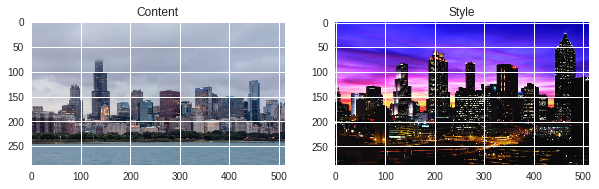

0
tf.Tensor(3971071.0, shape=(), dtype=float32) best tf.Tensor(3971071.0, shape=(), dtype=float32)


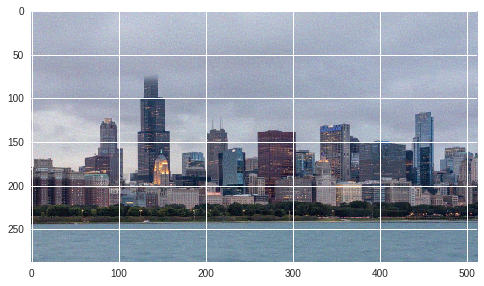

100
tf.Tensor(600062.1, shape=(), dtype=float32) best tf.Tensor(600062.1, shape=(), dtype=float32)


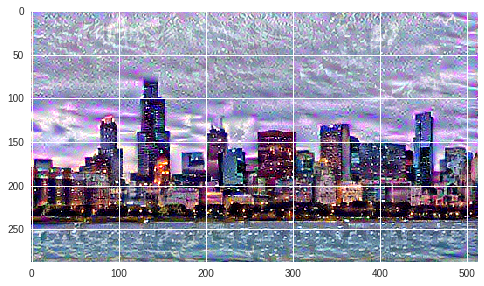

In [60]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

content_path = 'Chicago.jpg'
style_path = 'Atlanta.jpg'

show_content_style(content_path, style_path)

best, best_loss = run_style_transfer(content_path, style_path, iterations=2000)

files.download('Result.jpg')